# Importing Libraries and Cleaned Datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import warnings
warnings.filterwarnings('ignore')

county_health_rank = pd.read_csv('county_rankings25.csv')
fips_codes = pd.read_csv('all_fips.csv')
county_vars = pd.read_csv('county_vars_2.csv')
ltss_2022 = pd.read_csv('ltss_2022.csv')
race_groups = pd.read_csv('agg_race_variables.csv')

In [21]:
import scipy.stats as stats

In [76]:
import os

# Data Cleaning Plan
## County Health Rankings 2025
In place of the previousl 4 tables reporting socio economic metrics, I found a new Dataset 'County Health Rankings.' The data wrangling process will involve selecting the target variables, renaming, normalizing data types, validating the resulting dataframe, and applying the standardized hierarchical index (county, state).

Since dataset contains hundreds of variables, I created a small dataframe of our variables of interest and normalized names to facilate creating the subset itself and its naming conventions. 

Note: much of the numeric data is in percentages, separate subsets will include totals and percentages and will be used depnding on type of analysis and indexing needed.


## LTSS Enrollment and Expenditure tables
The state-level LTSS enrollment and expenditure tables remain and their cleaning involves: subsetting by columns neeeded reporting metrics for enrollment and expenses. These variables reflect enrollment in the first table and expenses in the second for (1)The entire LTSS program, (2) Institutional care, and (3)HCBS program. 

I will subset each table by thsese colums, rename by the conventions defined at the beginning of the section, remove invalid characters ('$', ',') from numeric columns, change the datatypes of the columns to floats for quantitative variables ans strings for 'id' variables, and set 'state' as index prior to merging.

## FIPS & States ID table
I will merge both tables above to a previosly created 'all_fips' (which serves as a sort of  'fact table'-listing county names, state names, state abbreviations, and corresponding fips codes) by index. 

I will validate the data and clean any merging errors like the creation of duplicate columns and/or changes to naming conventions (such as adding suffixes/prefixes to duplicate and original colums).

Finally, I will merge both of these new tables by the standardized index mentioned above.

# Data Cleaning

## LTSS Table

### Cleaning invalid characters in columns to prep for datatype conversion to float

In [2]:
# defining columns to keep and subsetting dataframes
ltss_cols= ['State', 'LTSS (total)']
ltss_population = ltss_2022[ltss_cols]

ltss_population['LTSS (total)'] = ltss_population['LTSS (total)'].str.replace(',', '').astype(float)
ltss_pop_names = {'State': 'state', 'LTSS (total)': 'ltss_state_enrollment'}
ltss_population = ltss_population.rename(columns=ltss_pop_names)
ltss_population.set_index(['state'])
# normalize state names
ltss_state_rename_enr = {'National': 'United States','District of\nColumbia':'District of Columbia'}
ltss_population['state'] = ltss_population['state'].replace(ltss_state_rename_enr)


## County Rankings tables

create subset, clean result, and merge with 'fips_codes'

In [3]:
county_health_subset = county_vars['raw_variable'].tolist()
new_names = county_vars[' new_name'].tolist()
county_health_cols = dict(zip(county_health_subset, new_names))
# creating subset and renaiming with list and dictionary from above
county_health= county_health_rank[county_health_subset]
county_health= county_health.rename(columns=county_health_cols)
# normalizing fips codes
county_health['fips'] = county_health['fips'].astype('str')
fips_codes['fips'] = fips_codes['fips'].astype('str')
#merging with fips codes
us_counties = pd.merge(county_health, fips_codes, how='outer', on='fips')
# creating new dataframe without non-county data to keep original dataframe for 'non_county' data subset
us_counties_updated = us_counties.dropna(subset=['state'])
# these are states, the US, and 'planning' regions
non_counties = us_counties[us_counties['state'].isnull()]

### clean new table

In [4]:
def clean_merge(us_counties_updated):
    # Drop columns: 'county_x', 'state_abbr_x'
    us_counties_updated = us_counties_updated.drop(columns=['county_x', 'state_abbr_x'])
    # Rename column 'county_y' to 'county'
    us_counties_updated = us_counties_updated.rename(columns={'county_y': 'county'})
    # Rename column 'state_abbr_y' to 'state_abbr'
    us_counties_updated = us_counties_updated.rename(columns={'state_abbr_y': 'state_abbr'})
    return us_counties_updated

In [5]:
# apply function, create list of states and 'us' to remove from county colums, and round values
us_counties_updated = clean_merge(us_counties_updated)
us_counties_updated = us_counties_updated.round(2)
state_names = fips_codes['state'].unique()
state_names = state_names.tolist()
state_names.append('United States')
us_counties_updated = us_counties_updated[~us_counties_updated['county'].isin(state_names)]

## subsets and groupings for drill-down analysis 

In [6]:
index = ['state_abbr','county','fips']

## Variable-based subsets

### Inequity Metrics

In [7]:
inequity_vars = ['state_abbr','county','fips', 'income_inequality', 'gender_pay_gap', 'school_segration_index', 'residential_segregation','school_funding_gap']
inequity_df = us_counties_updated[inequity_vars]

### Socio-economic indicators with racial breakdown

In [8]:
racial_category_subset = race_groups['raw_variable'].tolist()
racial_category_names = race_groups['new_name'].tolist()
racial_category_cols = dict(zip(racial_category_subset, racial_category_names))
race_categories = county_health_rank[racial_category_subset]

# cleaning new df:renaming with list and dictionary from above, changing dytypes, and rounding
race_categories= race_categories.rename(columns=racial_category_cols)
race_categories['fips'] = race_categories['fips'].astype('str')
race_categories = race_categories.round(2)
#race_categories =race_categories.fillna(0)

In [9]:
# reshape dataframe
# Melt the dataframe to long format
rc_long = race_categories.melt(
    id_vars=['state_abbr', 'county', 'fips', 'county_population'], 
    var_name='metric_race', 
    value_name='value'
)

# Split the combined 'metric_ethnicity' column
rc_long[['metric', 'race']] = rc_long['metric_race'].str.extract(r'(.+?)-(.+)')

# Drop the original combined column
rc_long = rc_long.drop(columns='metric_race')

# Pivot to have metrics as columns
race_metrics = rc_long.pivot_table(
    index=['state_abbr', 'county', 'fips', 'race', 'county_population'],
    columns='metric',
    values='value'
).reset_index()

# Clean up column names if needed
race_metrics.columns.name = None


In [10]:
# clean output 
race_metrics = race_metrics[~race_metrics['county'].isin(state_names)]
# drop all 0's in pupulation_percentage column since these counties don't report these populations and '0' will skew plotting for social indicators
race_metrics = race_metrics[race_metrics['population_percentage'] != 0.0]

### County-Level socio-economic outcomes (no racial breakdown)

In [11]:
county_socio_econ = us_counties_updated.drop(columns=['income_inequality', 'gender_pay_gap', 'school_segration_index', 'residential_segregation','school_funding_gap', 'child_mortality', 'child_poverty_percentage', 'firearm_fatalities',
       'life_expectancy', 'median_income', 'premature_death'])

## Total Values (vs percentages)

### Counties 

In [12]:
pop_vars = ['state_abbr','county','fips', 'population']
county_pop = us_counties_updated[pop_vars]
# find columns w percentage ouputs by assigining target string to variable ans using lamda  func to filter col names and assign to list
percent_str = 'percentage'
percent_vars = list(filter(lambda x: percent_str in x, new_names))
us_counties_totals = us_counties_updated.copy()
counties_pop_col = 'population'

#### totals function

In [13]:
# multiplies each percentage column by county polulation to yield total amounts
def calc_total_pop(df, cols, pop_col):
    for i in df[cols]:
        df[i] = df[i] * df[pop_col]
    return df


In [14]:
us_counties_totals = calc_total_pop(us_counties_totals, percent_vars, counties_pop_col)
us_counties_totals.columns = us_counties_totals.columns.str.replace('_percentage', '')

### Totals- broken down by race

In [15]:
race_pop_col = 'county_population'
race_percentage_vars = [ 'population_percentage', 'child_poverty_percentage']
racial_breakdown_total = race_metrics.copy()
racial_breakdown_total = calc_total_pop(racial_breakdown_total, race_percentage_vars, race_pop_col)
racial_breakdown_total = racial_breakdown_total.round(2)

In [16]:
racial_breakdown_total.columns = racial_breakdown_total.columns.str.replace('_percentage', '')

Note: Many missing values

## Merge for Analysis

In [ ]:
test_race_metrics = race_metrics
test_inequitydf = inequity_df
test_race_metrics.reset_index(inplace=True)
test_inequitydf.reset_index(inplace=True)

In [ ]:
race_inequity_df = pd.merge(test_race_metrics, test_inequitydf, on=['state_abbr','county','fips'], how='left')

# Insights

## State_level

## County-Level 

### Data Description

In [17]:
us_counties_updated.describe()

,hs_diploma_percentage,unemployed_percentage,population,median_income,school_segration_index,gender_pay_gap,uninsured__percentage,school_funding_gap,residential_segregation,premature_death,income_inequality,child_poverty_percentage,life_expectancy,child_mortality,high_housing_cost_percentage,firearm_fatalities,child_care_cost_burden
count,3130.000000,3137.000000,3.130000e+03,3129.000000,2917.000000,3121.000000,3129.000000,3051.000000,2054.000000,3085.000000,3109.000000,3129.000000,3065.000000,2046.000000,3130.000000,2294.000000,3136.000000
mean,0.887581,0.035901,1.056191e+05,65476.885906,0.082005,0.786450,0.104842,-472.237899,49.458544,10380.807125,4.558260,0.190013,75.152480,64.606124,0.099744,17.798727,0.285835
std,0.054816,0.012209,3.324455e+05,16472.832698,0.075179,0.102187,0.046583,6815.512165,16.649814,3786.531271,0.810306,0.080525,3.608277,25.822974,0.033694,8.392230,0.070344
min,0.470000,0.000000,4.300000e+01,28579.000000,0.000000,0.380000,0.020000,-46776.990000,1.440000,3315.250000,2.270000,0.030000,53.980000,19.010000,0.000000,1.860000,0.120000
25%,0.860000,0.030000,1.075475e+04,54610.000000,0.030000,0.730000,0.070000,-3056.865000,38.220000,7731.190000,4.020000,0.130000,72.780000,47.037500,0.080000,12.110000,0.230000
50%,0.900000,0.030000,2.592950e+04,62758.000000,0.060000,0.790000,0.090000,19.120000,50.365000,9824.460000,4.420000,0.180000,75.270000,59.820000,0.100000,16.640000,0.280000
75%,0.930000,0.040000,6.875575e+04,73004.000000,0.110000,0.840000,0.130000,2602.765000,60.717500,12368.580000,4.950000,0.230000,77.540000,75.597500,0.120000,21.987500,0.330000
max,1.000000,0.170000,9.663345e+06,173655.000000,0.640000,1.870000,0.380000,35429.370000,92.420000,46417.850000,10.500000,0.630000,94.220000,326.690000,0.300000,79.460000,0.650000


In [18]:
inequity_df.describe()

,income_inequality,gender_pay_gap,school_segration_index,residential_segregation,school_funding_gap
count,3109.000000,3121.000000,2917.000000,2054.000000,3051.000000
mean,4.558260,0.786450,0.082005,49.458544,-472.237899
std,0.810306,0.102187,0.075179,16.649814,6815.512165
min,2.270000,0.380000,0.000000,1.440000,-46776.990000
25%,4.020000,0.730000,0.030000,38.220000,-3056.865000
50%,4.420000,0.790000,0.060000,50.365000,19.120000
75%,4.950000,0.840000,0.110000,60.717500,2602.765000
max,10.500000,1.870000,0.640000,92.420000,35429.370000


### Correlation and Covariance

<Axes: >

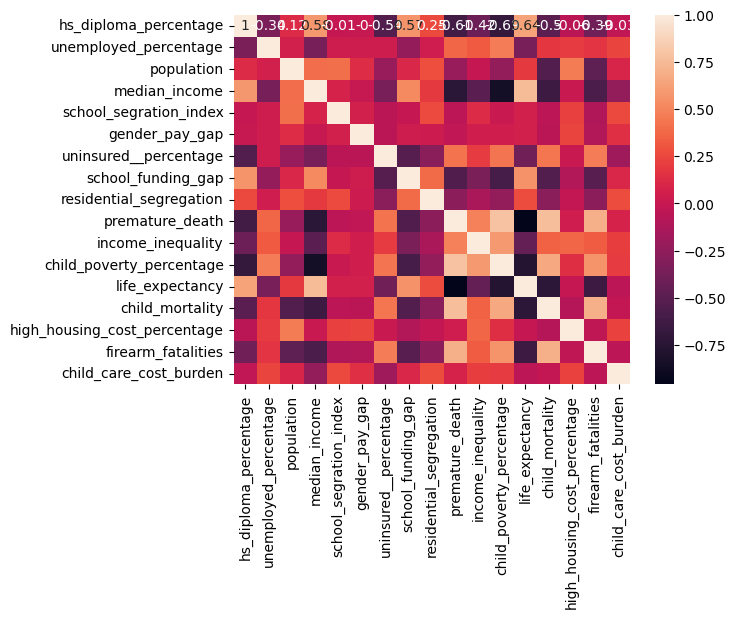

In [22]:
matrix = us_counties_updated.corr(method='spearman', numeric_only=True).round(2)
sns.heatmap(matrix, annot=True)

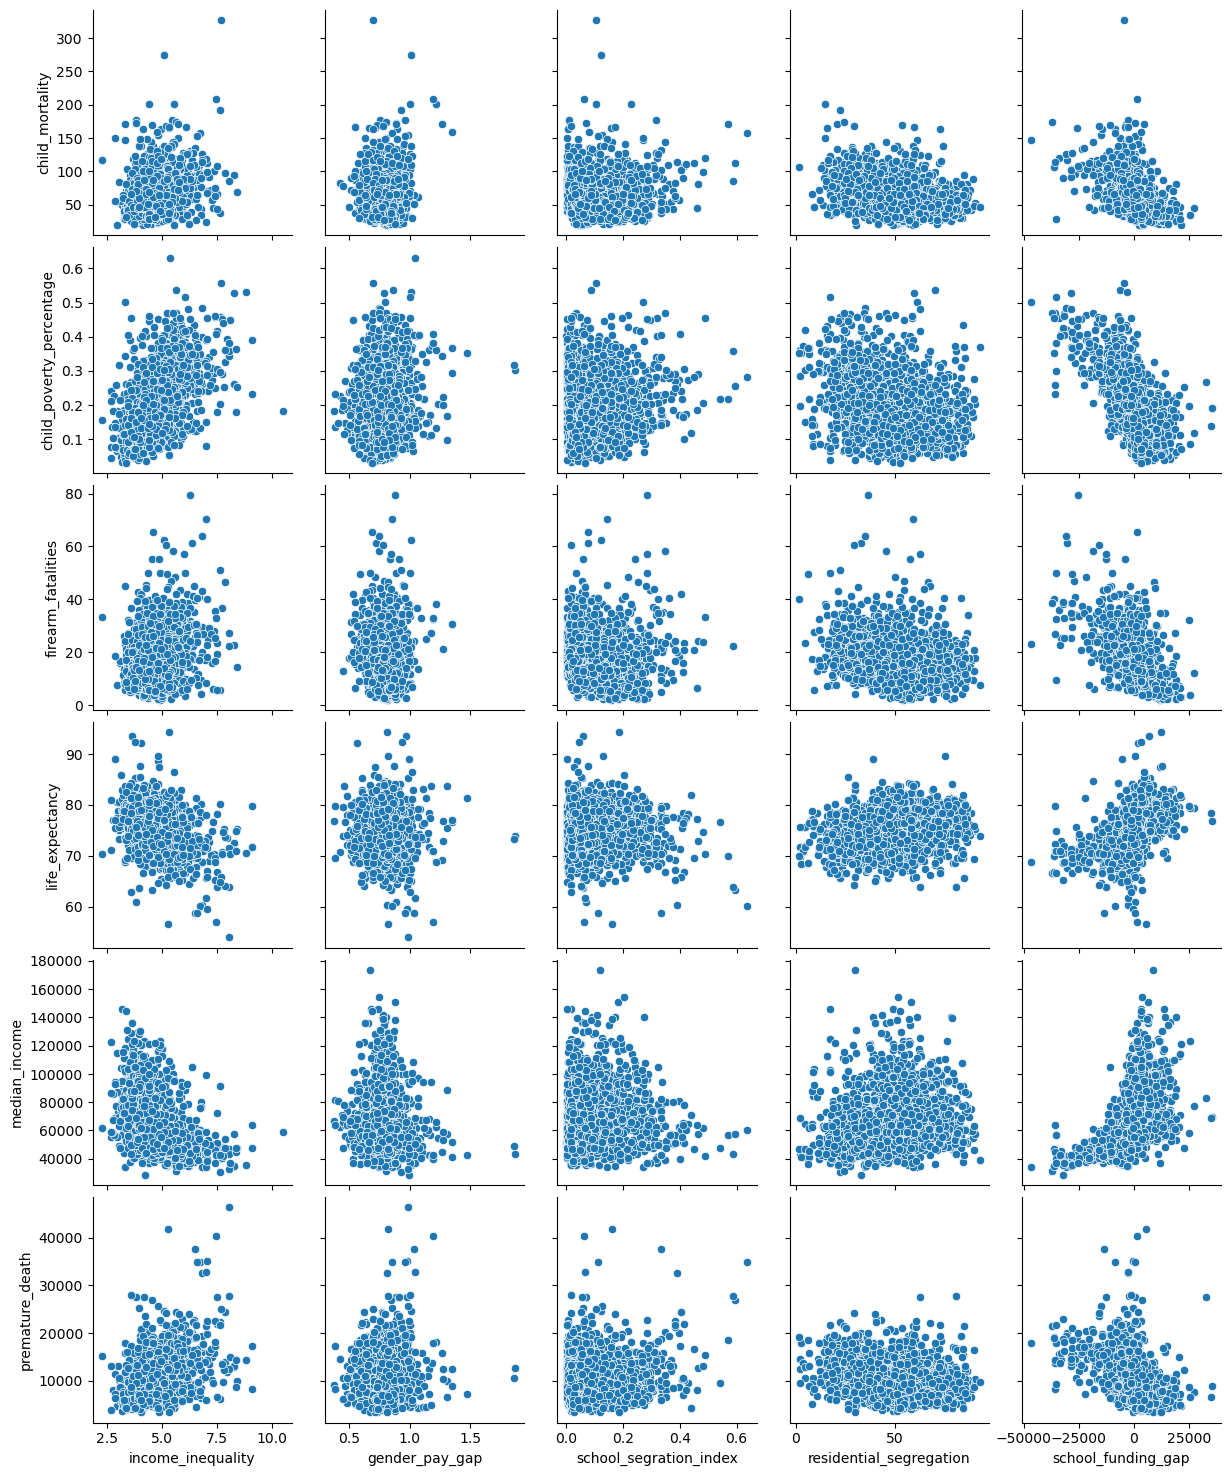

In [74]:
sns.pairplot(us_counties, 
    x_vars= ['income_inequality', 'gender_pay_gap', 'school_segration_index', 'residential_segregation','school_funding_gap'],
    y_vars= ['child_mortality', 'child_poverty_percentage','firearm_fatalities', 'life_expectancy', 'median_income', 'premature_death'],
    )     

### Distributions

#### Income Inequality

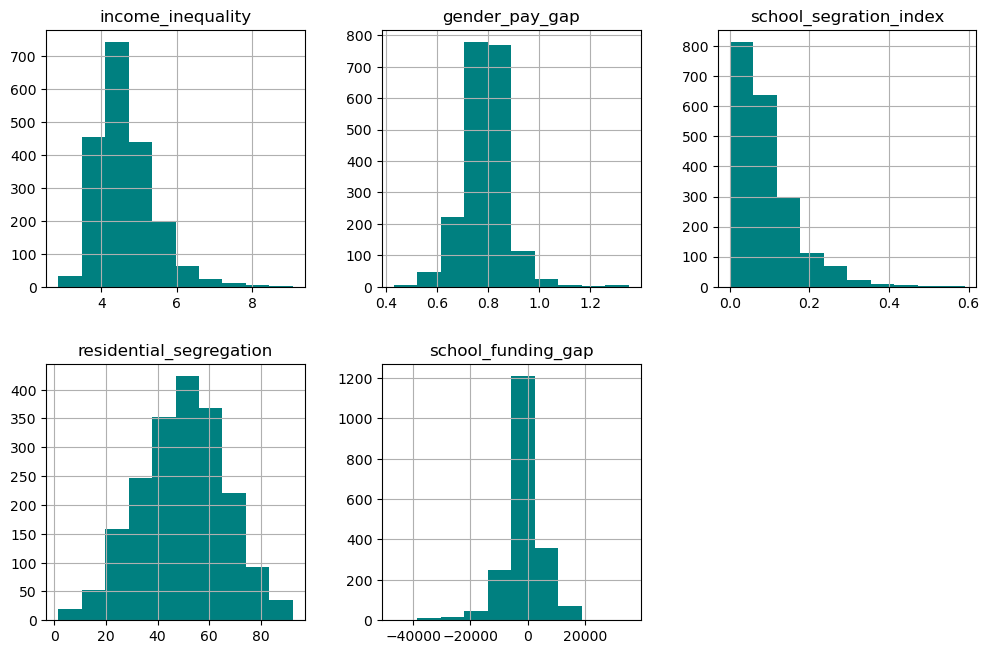

In [80]:
inequity_df.hist(figsize=(12,12), layout=(3,3), color='teal', ec='black', sharex=False);

#### Social Indicators

In [28]:
county_socio_econ = county_socio_econ.drop(columns='population')

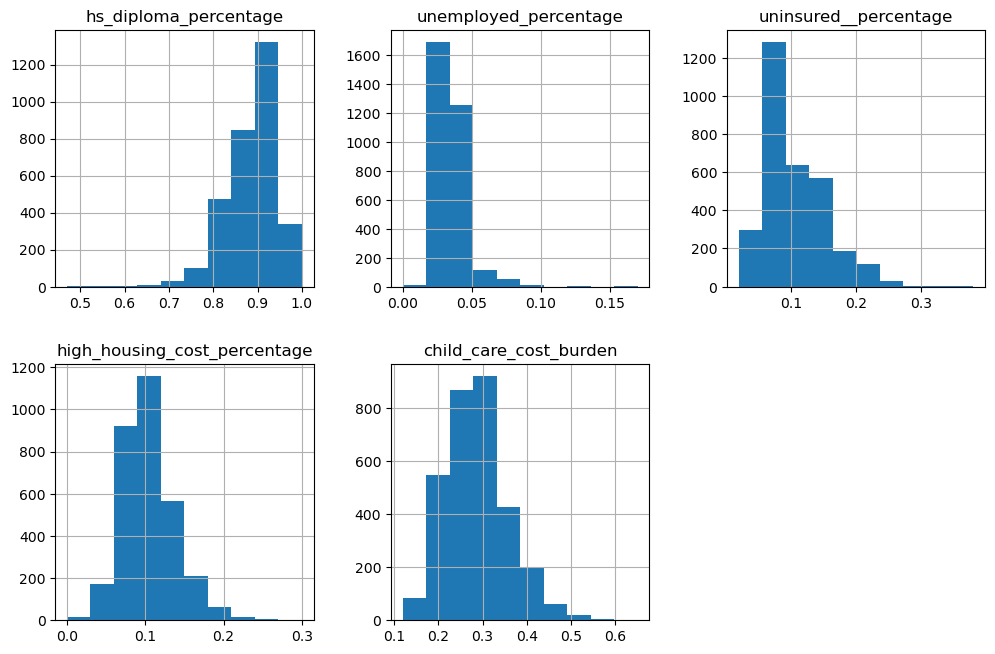

In [29]:
county_socio_econ.hist(figsize=(12,12), layout=(3,3), sharex=False);

In [ ]:

plt.show()

### Regression

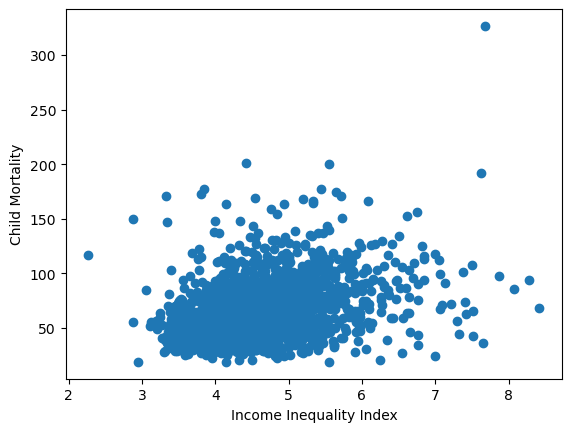

In [24]:
fig, ax = plt.subplots()  
ax.scatter(us_counties_updated['income_inequality'], us_counties_updated['child_mortality'])  
ax.set_xlabel('Income Inequality Index')  
ax.set_ylabel('Child Mortality')  
plt.show()

## Drill down on race

### Pair Plots

In [ ]:
race_anlysis = race_metrics.copy()
race_anlysis = race_anlysis.drop(columns=['county_population', 'population_percentage'])

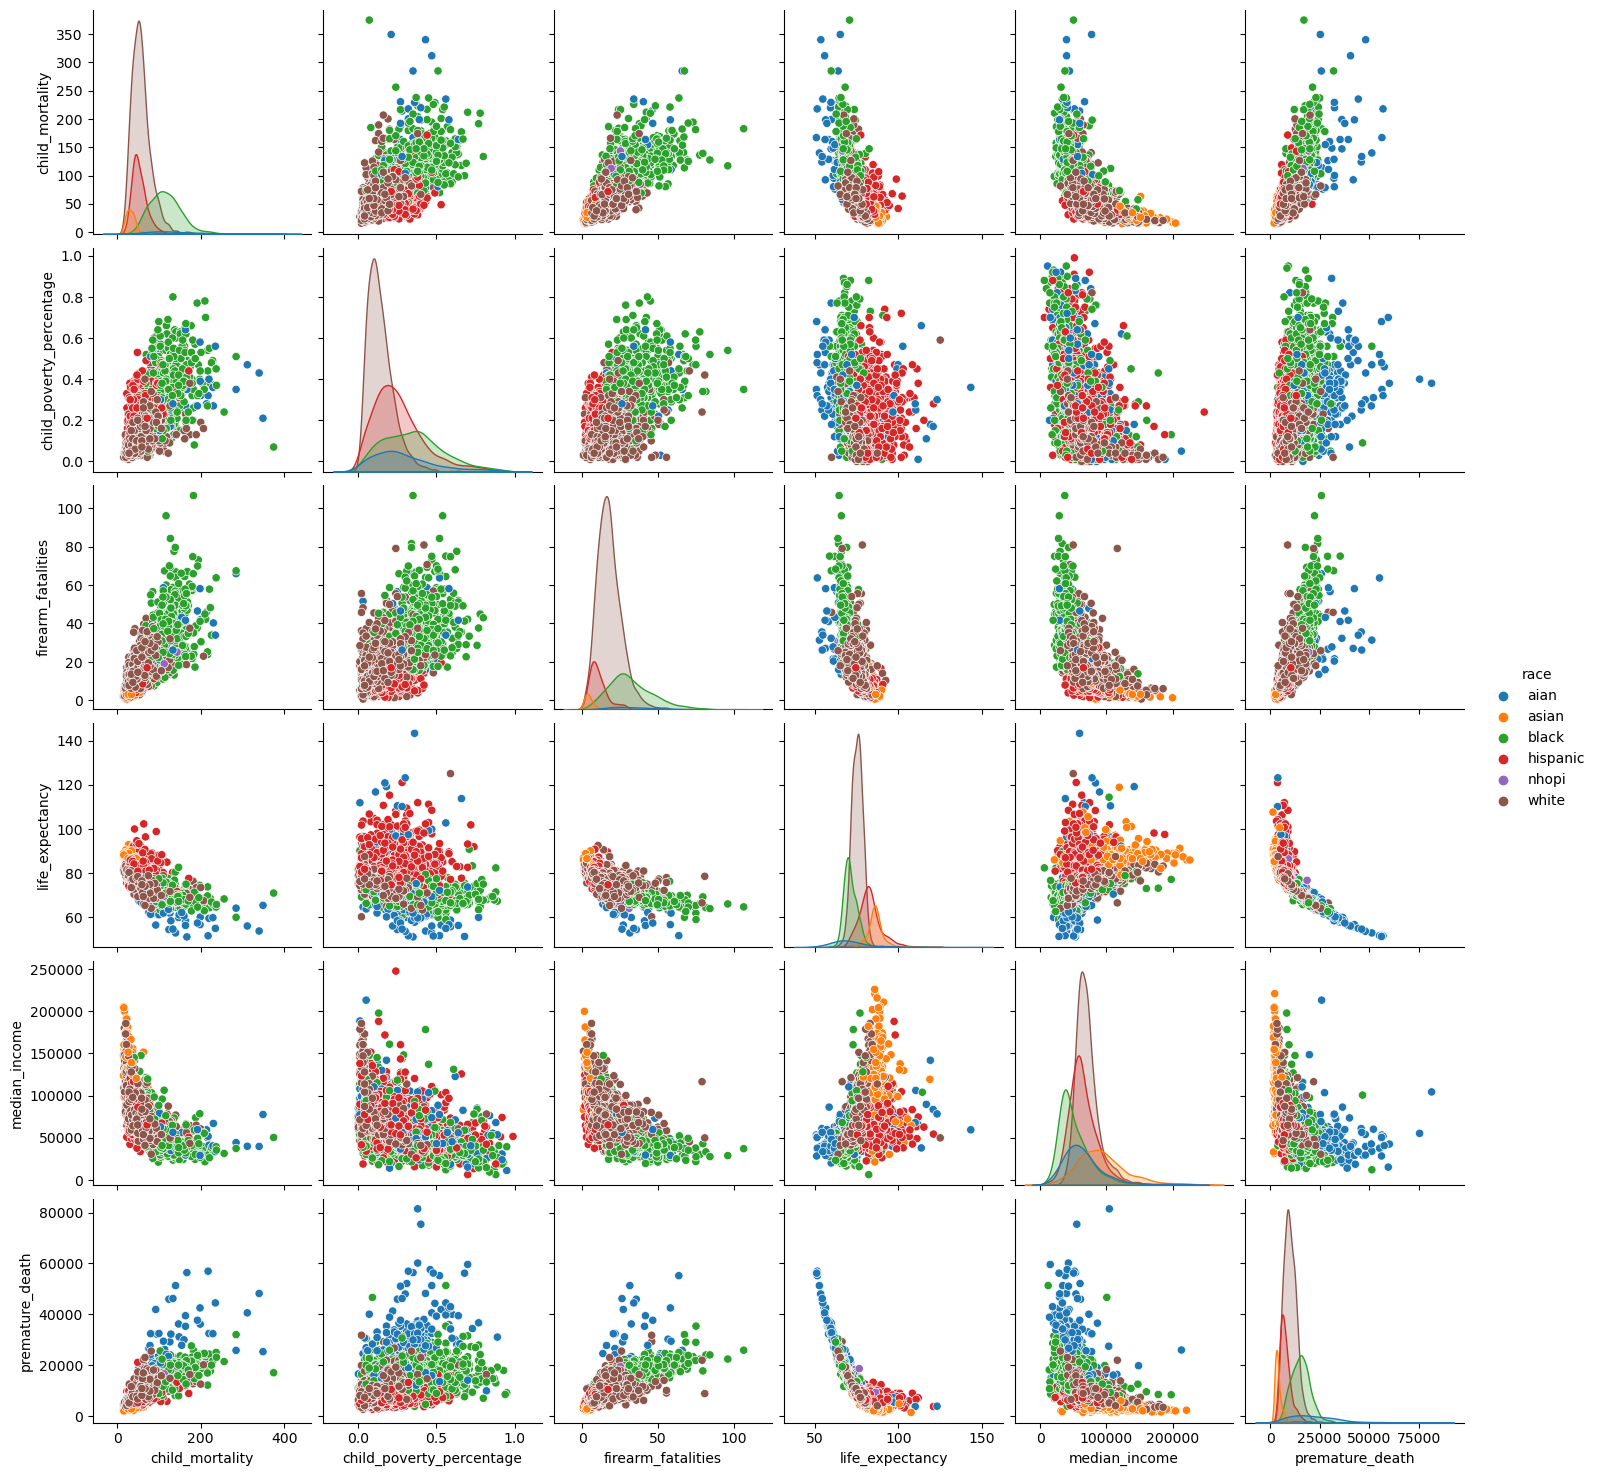

In [33]:
sns.pairplot(race_anlysis, hue='race')

In [ ]:
df_test = race_anlysis.merge(inequity_df, on=index)
inequity_df = inequity_df.dropna()

### Comparing distributions between income inequality groupings: 'above_median' and 'below_median'

In [ ]:
print(us_counties_updated['income_inequality'].median())